In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import matplotlib.patches as patches
import tensorflow as tf
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout
from keras.models import Sequential, load_model
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from mtcnn.mtcnn import MTCNN
import concurrent.futures

In [2]:
# Define paths
images_path = r"F:\CurrentWork\FaceMaskDetection\Data\images"
annotations_path = r"F:\CurrentWork\FaceMaskDetection\Data\annotations"
train_df = pd.read_csv(r"F:\CurrentWork\FaceMaskDetection\train.csv")
submission_df = pd.read_csv(r"F:\CurrentWork\FaceMaskDetection\submission.csv")


In [3]:
# Initial data insights
print(len(train_df))


15412


In [4]:
print(train_df.head())

       name   x1   x2   y1   y2       classname
0  2756.png   69  126  294  392  face_with_mask
1  2756.png  505   10  723  283  face_with_mask
2  2756.png   75  252  264  390   mask_colorful
3  2756.png  521  136  711  277   mask_colorful
4  6098.jpg  360   85  728  653    face_no_mask


In [5]:
print(len(submission_df))


8142


In [6]:
print(submission_df.head())

       name  x1  x2  y1  y2  classname
0  1800.jpg NaN NaN NaN NaN        NaN
1  1800.jpg NaN NaN NaN NaN        NaN
2  1800.jpg NaN NaN NaN NaN        NaN
3  1799.jpg NaN NaN NaN NaN        NaN
4  1799.jpg NaN NaN NaN NaN        NaN


In [7]:
# Image file lists
image_files = sorted(os.listdir(images_path))
annotation_files = sorted(os.listdir(annotations_path))

In [8]:
print(len(annotation_files), len(image_files))

4326 6024


In [9]:
# Split data into training and test images
train_images = image_files[1698:]
test_images = image_files[:1698]

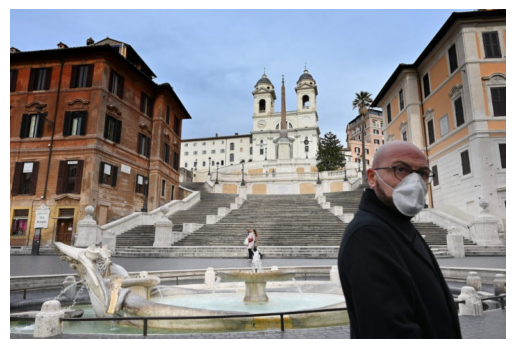

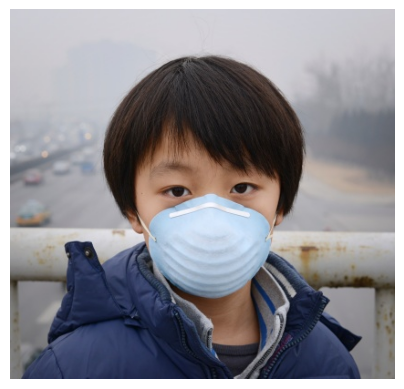

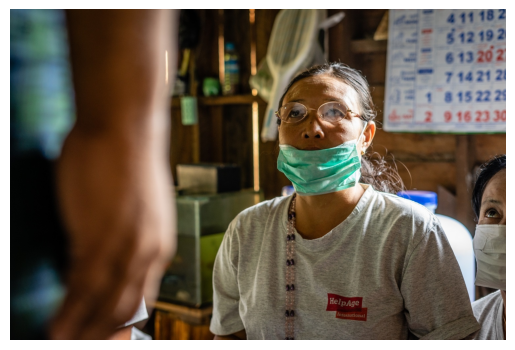

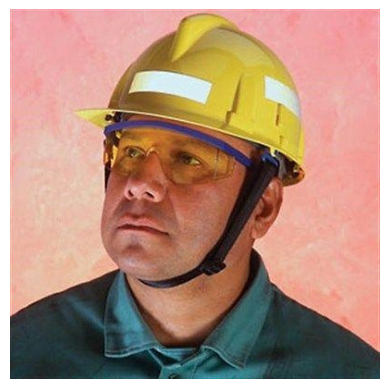

In [10]:
# Display example images
for index in [5, 2, 200, 22]:
    img = plt.imread(os.path.join(images_path, train_images[index]))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [11]:
# Filter training data
options = ['face_with_mask', 'face_no_mask']
train_df = train_df[train_df['classname'].isin(options)].sort_values('name').reset_index(drop=True)


In [12]:
# Create bounding boxes
train_df['bbox'] = train_df[['x1', 'x2', 'y1', 'y2']].values.tolist()


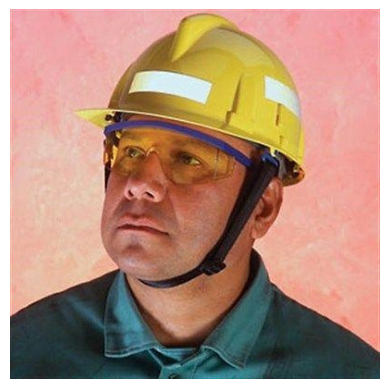

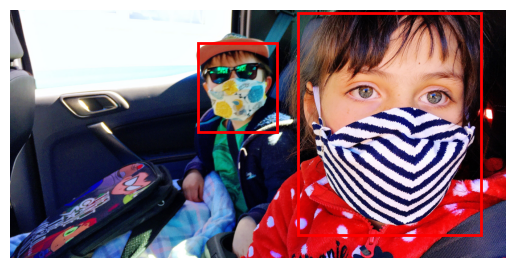

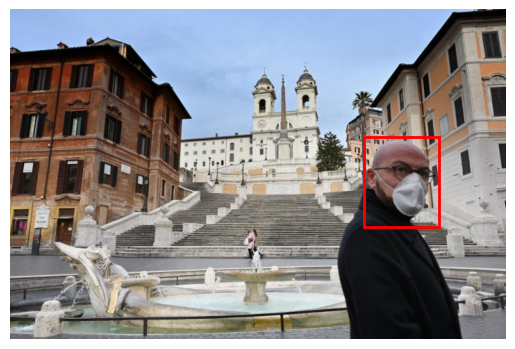

In [13]:
# Function to get bounding boxes for an image ID
def get_boxes(image_id):
    return train_df[train_df["name"] == str(image_id)]["bbox"].tolist()

# Visualize bounding boxes for sample images
for image_id in [22, 24, 5]:
    boxes = get_boxes(train_images[image_id])
    img = plt.imread(os.path.join(images_path, train_images[image_id]))

    fig, ax = plt.subplots(1)
    ax.imshow(img)
    for box in boxes:
        rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1],
                                 linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    plt.axis('off')
    plt.show()

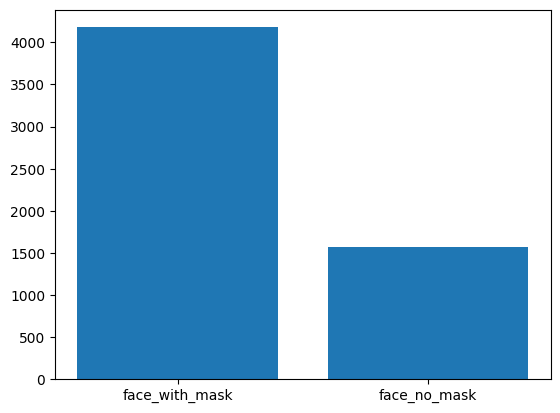

In [14]:
# Plot class distribution
plt.bar(['face_with_mask', 'face_no_mask'], train_df.classname.value_counts())
plt.show()

In [15]:
# Prepare image data for training
img_size = 50
data = []

def create_data():
    for _, row in train_df.iterrows():
        # Load image in grayscale
        img_path = os.path.join(images_path, row['name'])
        img_array = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        # Check if the image was loaded successfully
        if img_array is None:
            print(f"Error loading image: {img_path}")
            continue

        # Validate cropping coordinates
        height, width = img_array.shape
        y1, y2, x1, x2 = row['y1'], row['y2'], row['x1'], row['x2']
        
        # Ensure cropping coordinates are within image bounds
        if (y1 < 0 or y2 > height or x1 < 0 or x2 > width or y1 >= y2 or x1 >= x2):
            print(f"Invalid cropping coordinates for image: {img_path} - Coordinates: ({x1}, {y1}), ({x2}, {y2})")
            continue
        
        # Crop and resize the image
        crop_image = img_array[y1:y2, x1:x2]
        new_img_array = cv2.resize(crop_image, (img_size, img_size))
        data.append([new_img_array, row['classname']])

# Call the function to create the dataset
create_data()


Invalid cropping coordinates for image: F:\CurrentWork\FaceMaskDetection\Data\images\1801.jpg - Coordinates: (451, 895), (186, 697)
Invalid cropping coordinates for image: F:\CurrentWork\FaceMaskDetection\Data\images\1802.jpg - Coordinates: (110, 273), (71, 272)
Invalid cropping coordinates for image: F:\CurrentWork\FaceMaskDetection\Data\images\1803.jpg - Coordinates: (126, 303), (75, 333)
Invalid cropping coordinates for image: F:\CurrentWork\FaceMaskDetection\Data\images\1805.jpg - Coordinates: (728, 853), (180, 336)
Invalid cropping coordinates for image: F:\CurrentWork\FaceMaskDetection\Data\images\1806.jpg - Coordinates: (509, 617), (184, 313)
Invalid cropping coordinates for image: F:\CurrentWork\FaceMaskDetection\Data\images\1809.jpg - Coordinates: (915, 1419), (78, 742)
Invalid cropping coordinates for image: F:\CurrentWork\FaceMaskDetection\Data\images\1810.jpg - Coordinates: (581, 693), (198, 317)
Invalid cropping coordinates for image: F:\CurrentWork\FaceMaskDetection\Data\

In [16]:
# Split data into features and labels
x, y = zip(*data)
x = np.array(x).reshape(-1, img_size, img_size, 1)
y = LabelEncoder().fit_transform(y)
y = to_categorical(y)

In [17]:
# Normalize input data
x = tf.keras.utils.normalize(x, axis=1)

In [18]:
# Define the model
model = Sequential([
    Conv2D(100, (3, 3), activation='relu', input_shape=x.shape[1:], strides=2),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(50, activation='relu'),
    Dropout(0.2),
    Dense(2, activation='softmax')
])

In [19]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3, decay=1e-5), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [20]:
# Train the model
model.fit(x, y, epochs=70, batch_size=10)

Epoch 1/70
84/84 [==============================] - 6s 8ms/step - loss: 0.6351 - accuracy: 0.6819
Epoch 2/70
84/84 [==============================] - 1s 7ms/step - loss: 0.6292 - accuracy: 0.6855
Epoch 3/70
84/84 [==============================] - 1s 8ms/step - loss: 0.6308 - accuracy: 0.6855
Epoch 4/70
84/84 [==============================] - 1s 8ms/step - loss: 0.6349 - accuracy: 0.6855
Epoch 5/70
84/84 [==============================] - 1s 8ms/step - loss: 0.6322 - accuracy: 0.6855
Epoch 6/70
84/84 [==============================] - 1s 8ms/step - loss: 0.6289 - accuracy: 0.6855
Epoch 7/70
84/84 [==============================] - 0s 6ms/step - loss: 0.6229 - accuracy: 0.6855
Epoch 8/70
84/84 [==============================] - 1s 6ms/step - loss: 0.6258 - accuracy: 0.6855
Epoch 9/70
84/84 [==============================] - 0s 5ms/step - loss: 0.6261 - accuracy: 0.6855
Epoch 10/70
84/84 [==============================] - 0s 6ms/step - loss: 0.6285 - accuracy: 0.6855
Epoch 11/70
84/84 [

In [21]:
model.save('model_01.h5')
print("Model saved successfully.")

Model saved successfully.


In [22]:
# Function to detect faces in an image
def detect_faces_in_image(image_name, use_cv2=False):
    detector = MTCNN()
    img = cv2.imread(os.path.join(images_path, image_name)) if use_cv2 else plt.imread(os.path.join(images_path, image_name))
    faces = detector.detect_faces(img)
    return img, faces

In [23]:
# Function to make predictions on detected faces
def predict_mask_on_face(image, bounding_box):
    x, y, width, height = bounding_box
    face_img = image[y:y + height, x:x + width]
    face_img = cv2.cvtColor(face_img, cv2.COLOR_BGR2GRAY)
    resized_face = cv2.resize(face_img, (50, 50)).reshape(-1, 50, 50, 1)
    return np.argmax(model.predict(resized_face))

In [24]:
# Function to display an image with mask prediction
def display_test_image(image_name):
    img, faces = detect_faces_in_image(image_name, use_cv2=True)
    
    if len(faces) == 0:
        print(f"No face detected in {image_name}")
        return

    face = faces[0]
    mask_status = predict_mask_on_face(img, face['box'])
    
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.title('Mask Detected' if mask_status == 1 else 'Mask Not Detected', fontsize=14, color='green' if mask_status == 1 else 'red')
    plt.show()

1/1 [==============================] - 0s 201ms/step


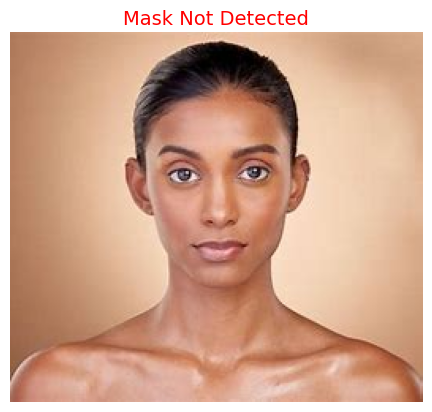

In [25]:
# Function to test a specific image
def test_single_image():
    # Use a hardcoded path or prompt the user for an image path
    full_image_path = r"F:\CurrentWork\FaceMaskDetection\Test\105.jpg"  # Hardcoded path for testing
    
    # Check if the file exists
    if os.path.isfile(full_image_path):
        display_test_image(full_image_path)  # Pass the full path to the display function
    else:
        print(f"The file {full_image_path} does not exist. Please check the filename.")

# Call the function to test a single image
test_single_image()


1/1 [==============================] - 0s 33ms/step


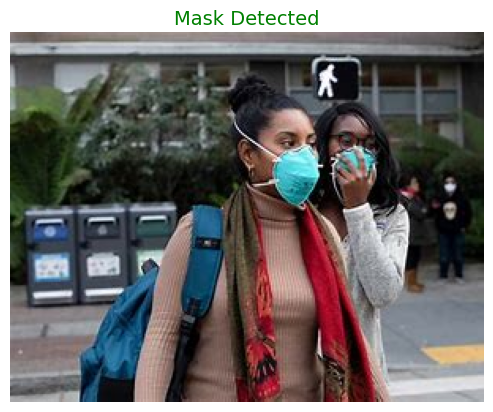

In [26]:
# Function to test a specific image
def test_single_image():
    # Use a hardcoded path or prompt the user for an image path
    full_image_path = r"F:\CurrentWork\FaceMaskDetection\Test\1.jpg"  # Hardcoded path for testing
    
    # Check if the file exists
    if os.path.isfile(full_image_path):
        display_test_image(full_image_path)  # Pass the full path to the display function
    else:
        print(f"The file {full_image_path} does not exist. Please check the filename.")

# Call the function to test a single image
test_single_image()


1/1 [==============================] - 0s 38ms/step


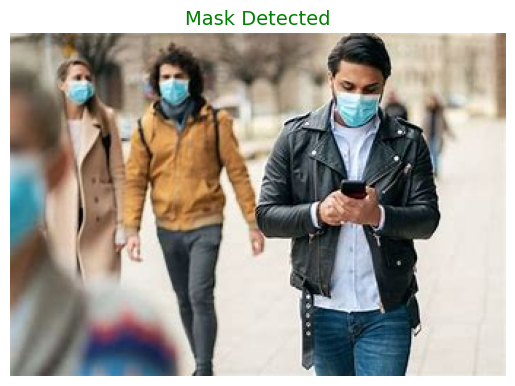

In [27]:
# Function to test a specific image
def test_single_image():
    # Use a hardcoded path or prompt the user for an image path
    full_image_path = r"F:\CurrentWork\FaceMaskDetection\Test\2.jpg"  # Hardcoded path for testing
    
    # Check if the file exists
    if os.path.isfile(full_image_path):
        display_test_image(full_image_path)  # Pass the full path to the display function
    else:
        print(f"The file {full_image_path} does not exist. Please check the filename.")

# Call the function to test a single image
test_single_image()


1/1 [==============================] - 0s 32ms/step


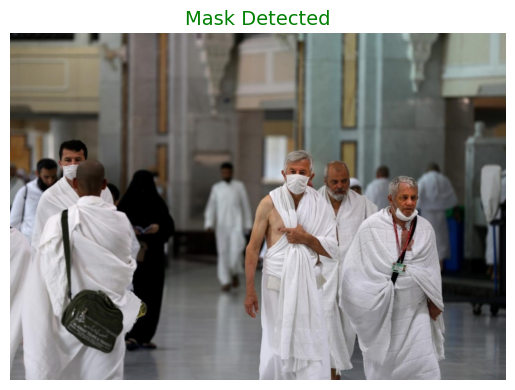

In [29]:
# Function to test a specific image
def test_single_image():
    # Use a hardcoded path or prompt the user for an image path
    full_image_path = r"F:\CurrentWork\FaceMaskDetection\Test\12.jpg"  # Hardcoded path for testing
    
    # Check if the file exists
    if os.path.isfile(full_image_path):
        display_test_image(full_image_path)  # Pass the full path to the display function
    else:
        print(f"The file {full_image_path} does not exist. Please check the filename.")

# Call the function to test a single image
test_single_image()


1/1 [==============================] - 0s 26ms/step


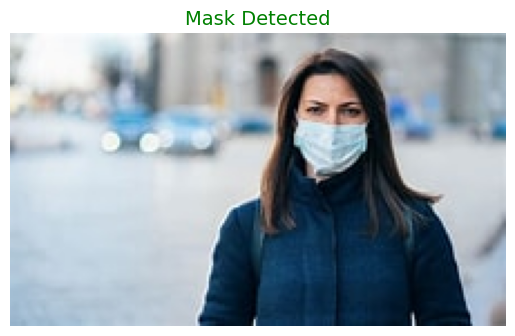

In [31]:
# Function to test a specific image
def test_single_image():
    # Use a hardcoded path or prompt the user for an image path
    full_image_path = r"F:\CurrentWork\FaceMaskDetection\Test\103.jpg"  # Hardcoded path for testing
    
    # Check if the file exists
    if os.path.isfile(full_image_path):
        display_test_image(full_image_path)  # Pass the full path to the display function
    else:
        print(f"The file {full_image_path} does not exist. Please check the filename.")

# Call the function to test a single image
test_single_image()


In [28]:
from sklearn.metrics import accuracy_score, mean_squared_error, classification_report, confusion_matrix
import numpy as np

# Function to evaluate the model on test data
def evaluate_model():
    # Assuming `test_images` is the test dataset (list of image filenames)
    true_labels = []
    predicted_labels = []

    for image_name in test_images:
        img, faces = detect_faces_in_image(image_name, use_cv2=True)
        if len(faces) > 0:
            face = faces[0]
            mask_status = predict_mask_on_face(img, face['box'])
            predicted_labels.append(mask_status)
            # Get the true label from `train_df` for the current image
            true_label = train_df[train_df['name'] == image_name]['classname'].iloc[0]
            true_labels.append(1 if true_label == 'face_with_mask' else 0)

    # Convert to numpy arrays
    true_labels = np.array(true_labels)
    predicted_labels = np.array(predicted_labels)

    # Accuracy
    acc = accuracy_score(true_labels, predicted_labels)
    print(f"Accuracy: {acc:.2f}")

    # Mean Squared Error (MSE)
    mse = mean_squared_error(true_labels, predicted_labels)
    print(f"Mean Squared Error (MSE): {mse:.2f}")

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(true_labels, predicted_labels, target_names=['No Mask', 'With Mask']))

    # Confusion Matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    print("\nConfusion Matrix:")
    print(cm)

    # SNR (Optional, depends on interpretation)
    signal = np.mean(predicted_labels)
    noise = np.var(predicted_labels - true_labels)
    snr = 10 * np.log10(signal / noise) if noise > 0 else float('inf')
    print(f"Signal-to-Noise Ratio (SNR): {snr:.2f} dB")

# Call the evaluation function
evaluate_model()


1/1 [==============================] - 0s 27ms/step


IndexError: single positional indexer is out-of-bounds